Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
ADME@NCATS is a resource developed by NCATS to host in silico prediction models for various ADME (Absorption, Distribution, Metabolism and Excretion) properties. The resource serves as an important tool for the drug discovery community with potential uses in compound optimization and prioritization. The models were retrospectively validated on a subset of marketed drugs which resulted in very good accuracies.

Data that were used for developing the models are made publicly accessible by depositing them into PubChem database. In some instances, when complete data cannot be made public, a subset of the data are deposited into PubChem. Links to the PubChem assays can be found in the individual model pages. The users are highly encouraged to use these data for development and validation of QSAR models.

## Assay Information
Aqueous solubility is one of the most important properties in drug discovery, as it has profound impact on various drug properties, including biological activity, pharmacokinetics (PK), toxicity, and in vivo efficacy. Both kinetic and thermodynamic solubilities are determined during different stages of drug discovery and development. One way of assessing solubility is as follows:

![image.png](https://storage.googleapis.com/polaris-public/readme/datasets/img/04_02_ADME_NCATS_Solubility_data_curation.jpeg)

Image is from [here](https://www.emdmillipore.com/CA/en/product/MultiScreenHTS-PCF-Filter-Plates-for-Solubility-Assays,MM_NF-C8875?ReferrerURL=https%3A%2F%2Fwww.google.com%2F).


## Description of readout:
- **PUBCHEM_ACTIVITY_OUTCOME**: Corresponds to the phenotype observed. For all compounds with Moderate/High phenotype, PUBCHEM_ACTIVITY_OUTCOME is "active" (class = 1). For all        compounds with Low phenotype, PUBCHEM_ACTIVITY_OUTCOME is "inactive" (class = 0).
- **PUBCHEM_ACTIVITY_SCORE**: Whole number in Solubility (ug/mL) of the compound.
- **PHENOTYPE**: Indicates type of activity observed: 0-10: Low Solubility (class = 0) >10: Moderate/High Solubility (class = 1)
- **KINETIC_AQUEOUS_SOLUBILITY**: Numerical value of the observed aqueous solubility, measured in ug/mL.

## Data resource

**Reference**: https://pubmed.ncbi.nlm.nih.gov/31176566/ 

**Raw data**: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645848

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import pandas as pd
import datamol as dm

root = pathlib.Path("__file__").absolute().parents[3]
# set to recipe root directory
os.chdir(root)
sys.path.insert(0, str(root))

In [6]:
org = "polaris"
data_name = "ncats_adme/Solubility"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"

All datasets were downloaded directly from Pubchem on 2024-03-21 by following the PubChem Bioassay links on https://opendata.ncats.nih.gov/adme/data.

In [9]:
# Load the data
source_data_path = f"{gcp_root}/data/raw/AID_1645848_raw.parquet"
data = pd.read_parquet(source_data_path)

Rows 0 and 1 are metadata; we will keep them separate.

In [10]:
meta_start = 0  # Start row index
meta_end = 2  # End row index + 1
data_meta = data.iloc[meta_start:(meta_end), :].copy()  # Save the metadata rows
data = data.drop(labels=list(range(meta_start, meta_end)), axis=0).reset_index(
    drop=True
)  # Drop those rows from the main dataframe
data_meta

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Kinetic Aqueous Solubility (ug/mL),Analysis Comment
0,RESULT_TYPE,NaN,NaN,None,None,NaN,NaN,NaN,STRING,STRING,STRING
1,RESULT_DESCR,NaN,NaN,None,None,NaN,NaN,NaN,Indicates type of activity observed: 0-10: Low...,Numerical value of the observed aqueous solubi...,Annotation/notes on a particular compound's da...


Drop the metadata rows and keep only the smiles, ID and outcome rows

In [11]:
# Keep only the SMILES, ID and outcome rows
columns_to_keep = [
    "PUBCHEM_SID",
    "PUBCHEM_EXT_DATASOURCE_SMILES",
    "PUBCHEM_ACTIVITY_OUTCOME",
    "PUBCHEM_ACTIVITY_SCORE",
    "Phenotype",
    "Kinetic Aqueous Solubility (ug/mL)",
]
data = data[columns_to_keep]
data.rename(columns={"PUBCHEM_EXT_DATASOURCE_SMILES": "SMILES"}, inplace=True)
# Rename Kinetic Aqueous Solubility (ug/mL) (we will specify minutes in the metadata)
data.rename(
    columns={"Kinetic Aqueous Solubility (ug/mL)": "Kinetic_Aqueous_Solubility"},
    inplace=True,
)
# Rename all columns to uppercase
for col in data.columns:
    data.rename(columns={col: col.upper()}, inplace=True)
# Drop rows where we don't have a solubility score (the other columns depend on this)
print(data.shape)
data.dropna(inplace=True, ignore_index=True)
print(f"after dropping inconclusive solubility: {data.shape}")

(2532, 6)
after dropping inconclusive solubility: (2456, 6)


We dropped ~80 compounds with inconclusive results.

In [12]:
data.describe()

,PUBCHEM_SID,PUBCHEM_ACTIVITY_SCORE
count,2.456000e+03,2456.000000
mean,1.851264e+08,19.962541
std,1.344467e+08,24.440681
min,8.437060e+05,0.000000
25%,8.965012e+07,1.000000
50%,1.610041e+08,4.000000
75%,3.636811e+08,39.000000
max,4.049047e+08,100.000000


Looking at the kinds of variables in each column:

In [13]:
data[
    [
        "PUBCHEM_ACTIVITY_OUTCOME",
        "PUBCHEM_ACTIVITY_SCORE",
        "PHENOTYPE",
        "KINETIC_AQUEOUS_SOLUBILITY",
    ]
].value_counts()

PUBCHEM_ACTIVITY_OUTCOME  PUBCHEM_ACTIVITY_SCORE  PHENOTYPE      KINETIC_AQUEOUS_SOLUBILITY
Inactive                  1.0                     Low            <1                            915
Active                    51.0                    Moderate/High  >51                            21
                          58.0                    Moderate/High  >58                            21
                          45.0                    Moderate/High  >45                            20
                          61.0                    Moderate/High  >61                            19
                                                                                              ... 
                          37.0                    Moderate/High  36.88                           1
                                                                 36.89                           1
                                                                 37.15                           1
                 

In [14]:
print(
    f'number of ">" assignments in kinetic aqueous solubility: {len([i for i in data['KINETIC_AQUEOUS_SOLUBILITY'].unique() if '>' in str(i)])}'
)
print(f'unique values in phenotype: {data['PHENOTYPE'].unique()}')

number of ">" assignments in kinetic aqueous solubility: 74
unique values in phenotype: ['Moderate/High' 'Low']


In [15]:
# Map active/inactive and stable/unstable to 1 and 0
data["PUBCHEM_ACTIVITY_OUTCOME"] = data["PUBCHEM_ACTIVITY_OUTCOME"].map(
    {"Active": 1.0, "Inactive": 0.0}
)
data["PHENOTYPE"] = data["PHENOTYPE"].map({"Moderate/High": 1.0, "Low": 0.0})

# Remove the '>' and '<' symbols from 'KINETIC_AQUEOUS_SOLUBILITY' values
data["KINETIC_AQUEOUS_SOLUBILITY"] = data["KINETIC_AQUEOUS_SOLUBILITY"].apply(
    lambda x: float(x.replace(">", "").replace("<", ""))
)

In [16]:
print(
    f"Number of soluble compounds based on column `PUBCHEM_ACTIVITY_OUTCOME`: {sum(data['PUBCHEM_ACTIVITY_OUTCOME']==1)}"
)
print(
    f"Number of soluble compounds based on column `PUBCHEM_ACTIVITY_SCORE`: {sum(data['PUBCHEM_ACTIVITY_SCORE']>10)}"
)
print(
    f"Number of soluble compounds based on column `KINETIC_AQUEOUS_SOLUBILITY`: {sum(data['KINETIC_AQUEOUS_SOLUBILITY']>10)}"
)

Number of soluble compounds based on column `PUBCHEM_ACTIVITY_OUTCOME`: 1056
Number of soluble compounds based on column `PUBCHEM_ACTIVITY_SCORE`: 1046
Number of soluble compounds based on column `KINETIC_AQUEOUS_SOLUBILITY`: 1056


The PUBCHEM_ACTIVITY_OUTCOME is computed based on PUBCHEM_ACTIVITY_OUTCOME instead of PUBCHEM_ACTIVITY_SCORE. 
Therefore, we keep readout PUBCHEM_ACTIVITY_OUTCOME and KINETIC_AQUEOUS_SOLUBILITY as categorical and continous data column respectfully. 

In [17]:
data.isna().any()

PUBCHEM_SID                   False
SMILES                        False
PUBCHEM_ACTIVITY_OUTCOME      False
PUBCHEM_ACTIVITY_SCORE        False
PHENOTYPE                     False
KINETIC_AQUEOUS_SOLUBILITY    False
dtype: bool

In [18]:
data.describe()

,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PHENOTYPE,KINETIC_AQUEOUS_SOLUBILITY
count,2.456000e+03,2456.000000,2456.000000,2456.000000,2456.000000
mean,1.851264e+08,0.429967,19.962541,0.429967,19.969126
std,1.344467e+08,0.495172,24.440681,0.495172,24.440162
min,8.437060e+05,0.000000,0.000000,0.000000,0.005000
25%,8.965012e+07,0.000000,1.000000,0.000000,1.000000
50%,1.610041e+08,0.000000,4.000000,0.000000,4.382000
75%,3.636811e+08,1.000000,39.000000,1.000000,39.280000
max,4.049047e+08,1.000000,100.000000,1.000000,100.000000


In [19]:
# Define data column names
data_cols = [
    "PUBCHEM_ACTIVITY_OUTCOME",
    "KINETIC_AQUEOUS_SOLUBILITY",
]
mol_col = "SMILES"

### Run preliminary curation for data inspection

In [40]:
data_cols

['PUBCHEM_ACTIVITY_OUTCOME', 'KINETIC_AQUEOUS_SOLUBILITY']

In [47]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import MoleculeCuration, OutlierDetection, Discretization, Deduplication, StereoIsomerACDetection, ContinuousDistributionVisualization

# Define the curation workflow
curator = Curator(
    data_path=source_data_path, 
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols = data_cols),
        ContinuousDistributionVisualization(y_cols=["PUBCHEM_ACTIVITY_OUTCOME"], bins=[0.5]),
        ContinuousDistributionVisualization(y_cols=['KINETIC_AQUEOUS_SOLUBILITY'], bins=[10]),
        OutlierDetection(method="zscore", columns=data_cols, threshold = 3, use_modified_zscore=True),
        StereoIsomerACDetection(y_cols=data_cols, threshold = 3)
    ],
    parallelized_kwargs = { "n_jobs": -1 }
)

curator.to_json(f"{dirname}/inspection_config.json")

In [48]:
# Run the curation step defined as above
data_inspection, report = curator(data)

2024-06-03 23:02:49.862 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-06-03 23:02:58.087 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-03 23:02:58.173 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-03 23:02:58.333 | INFO     | auroris.curation._curator:transform:106 - Performing step: outlier_detection
2024-06-03 23:02:58.521 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [49]:
#  get the curation logger
from auroris.report.broadcaster import LoggerBroadcaster

broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-06-03 23:02:49
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 425.
[IMG]: Dimensions 2400 x 600
[IMG]: Dimensions 1200 x 2400
===== distribution =====
[IMG]: Dimensions 1200 x 600
===== distribution =====
[IMG]: Dimensions 1200 x 600
===== outlier_detection =====
[LOG]: New column added: OUTLIER_PUBCHEM_ACTIVITY_OUTCOME
[LOG]: Found 0 potential outliers with resp

In [50]:
# Generate an HTML report with embedded visualizations showcasing the data analysis.
from utils.auroris_utils import HTMLBroadcaster

# export report to local directory
broadcaster = HTMLBroadcaster(report, f"{dirname}/inspection_report")
report_path = broadcaster.broadcast()

In [51]:
# check the curated data
data_inspection.describe(include='all')

,PUBCHEM_SID,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PHENOTYPE,KINETIC_AQUEOUS_SOLUBILITY,MOL_smiles,MOL_molhash_id,MOL_molhash_id_no_stereo,MOL_num_stereoisomers,MOL_num_undefined_stereoisomers,MOL_num_defined_stereo_center,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,OUTLIER_PUBCHEM_ACTIVITY_OUTCOME,OUTLIER_KINETIC_AQUEOUS_SOLUBILITY,AC_PUBCHEM_ACTIVITY_OUTCOME,AC_KINETIC_AQUEOUS_SOLUBILITY
count,2.456000e+03,2456,2456.000000,2456.000000,2456.000000,2456.000000,2456,2456,2456,2.456000e+03,2456.000000,2456.000000,2456.000000,2456.000000,2456,2456.0,2456,2456,2456,2456
unique,NaN,2454,NaN,NaN,NaN,NaN,2454,2454,2454,NaN,NaN,NaN,NaN,NaN,2,1.0,1,2,2,2
top,NaN,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)C3NC4=CC=C...,NaN,NaN,NaN,NaN,COc1ccc(C2Nc3ccccc3C(=O)N2Cc2ccco2)cc1COc1ccc(...,8e83d520d92f8a07dfc22d0c9c91c6a3ec3f7a6b,5b722d3c844e6405c6c6603c319ae804f34e183d,NaN,NaN,NaN,NaN,NaN,False,0.0,False,False,False,False
freq,NaN,2,NaN,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,2058,2456.0,2456,2439,2454,2454
mean,1.851264e+08,NaN,0.429967,19.962541,0.429967,19.969126,NaN,NaN,NaN,9.391535e+02,1.337134,0.197068,0.202769,0.399837,NaN,NaN,NaN,NaN,NaN,NaN
std,1.344467e+08,NaN,0.495172,24.440681,0.495172,24.440162,NaN,NaN,NaN,4.241856e+04,2.536484,0.980589,0.522808,1.113399,NaN,NaN,NaN,NaN,NaN,NaN
min,8.437060e+05,NaN,0.000000,0.000000,0.000000,0.005000,NaN,NaN,NaN,1.000000e+00,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.965012e+07,NaN,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,1.000000e+00,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.610041e+08,NaN,0.000000,4.000000,0.000000,4.382000,NaN,NaN,NaN,1.000000e+00,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.636811e+08,NaN,1.000000,39.000000,1.000000,39.280000,NaN,NaN,NaN,2.000000e+00,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


### Check the data distribution

<img src="inspection_report/images/3-Data_distribution_KINETIC_AQUEOUS_SOLUBILITY.png" width=600 height=300>

The solubulity are rather balenced between `soluble` and `insoluble` classes.

### Check activity shift between stereoisomers

Few activity shifts were detected in the dataset.
Let's check those molecules

In [54]:
data_inspection.loc[[964, 1803]]

,PUBCHEM_SID,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PHENOTYPE,KINETIC_AQUEOUS_SOLUBILITY,MOL_smiles,MOL_molhash_id,MOL_molhash_id_no_stereo,MOL_num_stereoisomers,MOL_num_undefined_stereoisomers,MOL_num_defined_stereo_center,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,OUTLIER_PUBCHEM_ACTIVITY_OUTCOME,OUTLIER_KINETIC_AQUEOUS_SOLUBILITY,AC_PUBCHEM_ACTIVITY_OUTCOME,AC_KINETIC_AQUEOUS_SOLUBILITY
964,124888752.0,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)C3NC4=CC=C...,1.0,15.0,1.0,14.83,COc1ccc(C2Nc3ccccc3C(=O)N2Cc2ccco2)cc1COc1ccc(...,8e83d520d92f8a07dfc22d0c9c91c6a3ec3f7a6b,5b722d3c844e6405c6c6603c319ae804f34e183d,2,2,0,1,1,True,False,False,False,True,False
1803,57655021.0,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)C3NC4=CC=C...,0.0,1.0,0.0,1.00,COc1ccc(C2Nc3ccccc3C(=O)N2Cc2ccco2)cc1COc1ccc(...,8e83d520d92f8a07dfc22d0c9c91c6a3ec3f7a6b,5b722d3c844e6405c6c6603c319ae804f34e183d,2,2,0,1,1,True,False,False,False,True,False


As we suspected, two samples with the same smiles but different SIDs are reported as being active or inactive. Looking at the molecules, they seem identical. We can't know which call is correct, so we should remove both. We'll do that below, after final curation.

SID 124888752 is [NCGC00066484-02](https://pubchem.ncbi.nlm.nih.gov/substance/124888752). SID 57655021 is [NCGC00168126-01](https://pubchem.ncbi.nlm.nih.gov/substance/57655021). The 2D representations are the same.

![image-2.png](inspection_report/images/6-Activity_shifts_among_stereoisomers__PUBCHEM_ACTIVITY_OUTCOME.png)

In [55]:
# Remove the above two samples
data_to_curate = data.query("PUBCHEM_SID not in [124888752, 57655021]").reset_index(drop = True)

### Re-run curation

In [56]:
# Define the final curation workflow
curator = Curator(
    source_data=source_data_path, 
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols = data_cols),
        Deduplication(deduplicate_on=mol_col, y_cols=data_cols), # remove the replicated molecules
        ContinuousDistributionVisualization(y_cols=["PUBCHEM_ACTIVITY_OUTCOME"], bins=[0.5]),
        ContinuousDistributionVisualization(y_cols=['KINETIC_AQUEOUS_SOLUBILITY'], bins=[10]),
        OutlierDetection(method="zscore", columns=data_cols, threshold = 3, use_modified_zscore=True),
        StereoIsomerACDetection(y_cols=data_cols, threshold = 3)
    ],
    parallelized_kwargs = { "n_jobs": -1 }
)

In [57]:
# The final curation configuration is exported for reproducibility
path = f"{gcp_root}/data/curation/curation_config.json"
curator.to_json(path)

In [58]:
# Run the curation step defined as above
data_curated, report = curator(data_to_curate)

2024-06-03 23:21:57.803 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-06-03 23:22:12.796 | INFO     | auroris.curation._curator:transform:106 - Performing step: deduplicate
2024-06-03 23:22:14.225 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-03 23:22:14.311 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-03 23:22:14.443 | INFO     | auroris.curation._curator:transform:106 - Performing step: outlier_detection
2024-06-03 23:22:14.622 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [59]:
broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-06-03 23:21:57
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 423.
[IMG]: Dimensions 2400 x 600
[IMG]: Dimensions 1200 x 2400
===== deduplicate =====
[LOG]: Deduplication merged and removed 1 duplicated molecules from dataset
===== distribution =====
[IMG]: Dimensions 1200 x 600
===== distribution =====
[IMG]: Dimensions 1200 x 600
===== outlier_detection =====
[

In [60]:
# Export report to polaris public directory on GCP
# The report is ready to reviewed in the HTML file.
broadcaster = HTMLBroadcaster(report, f"{gcp_root}/data/curation/report", embed_images=True)
broadcaster.broadcast()

'gs://polaris-public/polaris-recipes/org-polaris/ncats_adme/Solubility/data/curation/report/index.html'

## Export the final curated data

In [61]:
fout = f"{gcp_root}/data/curation/{data_name}_curated.csv"
data_curated.reset_index(drop=True).to_csv(fout, index=False)

The curation process has removed two samples from the dataset.

According to best practices suggested in a [recent paper on solubility determination](https://www.nature.com/articles/s41597-024-03105-6), we would want to follow this decision tree:

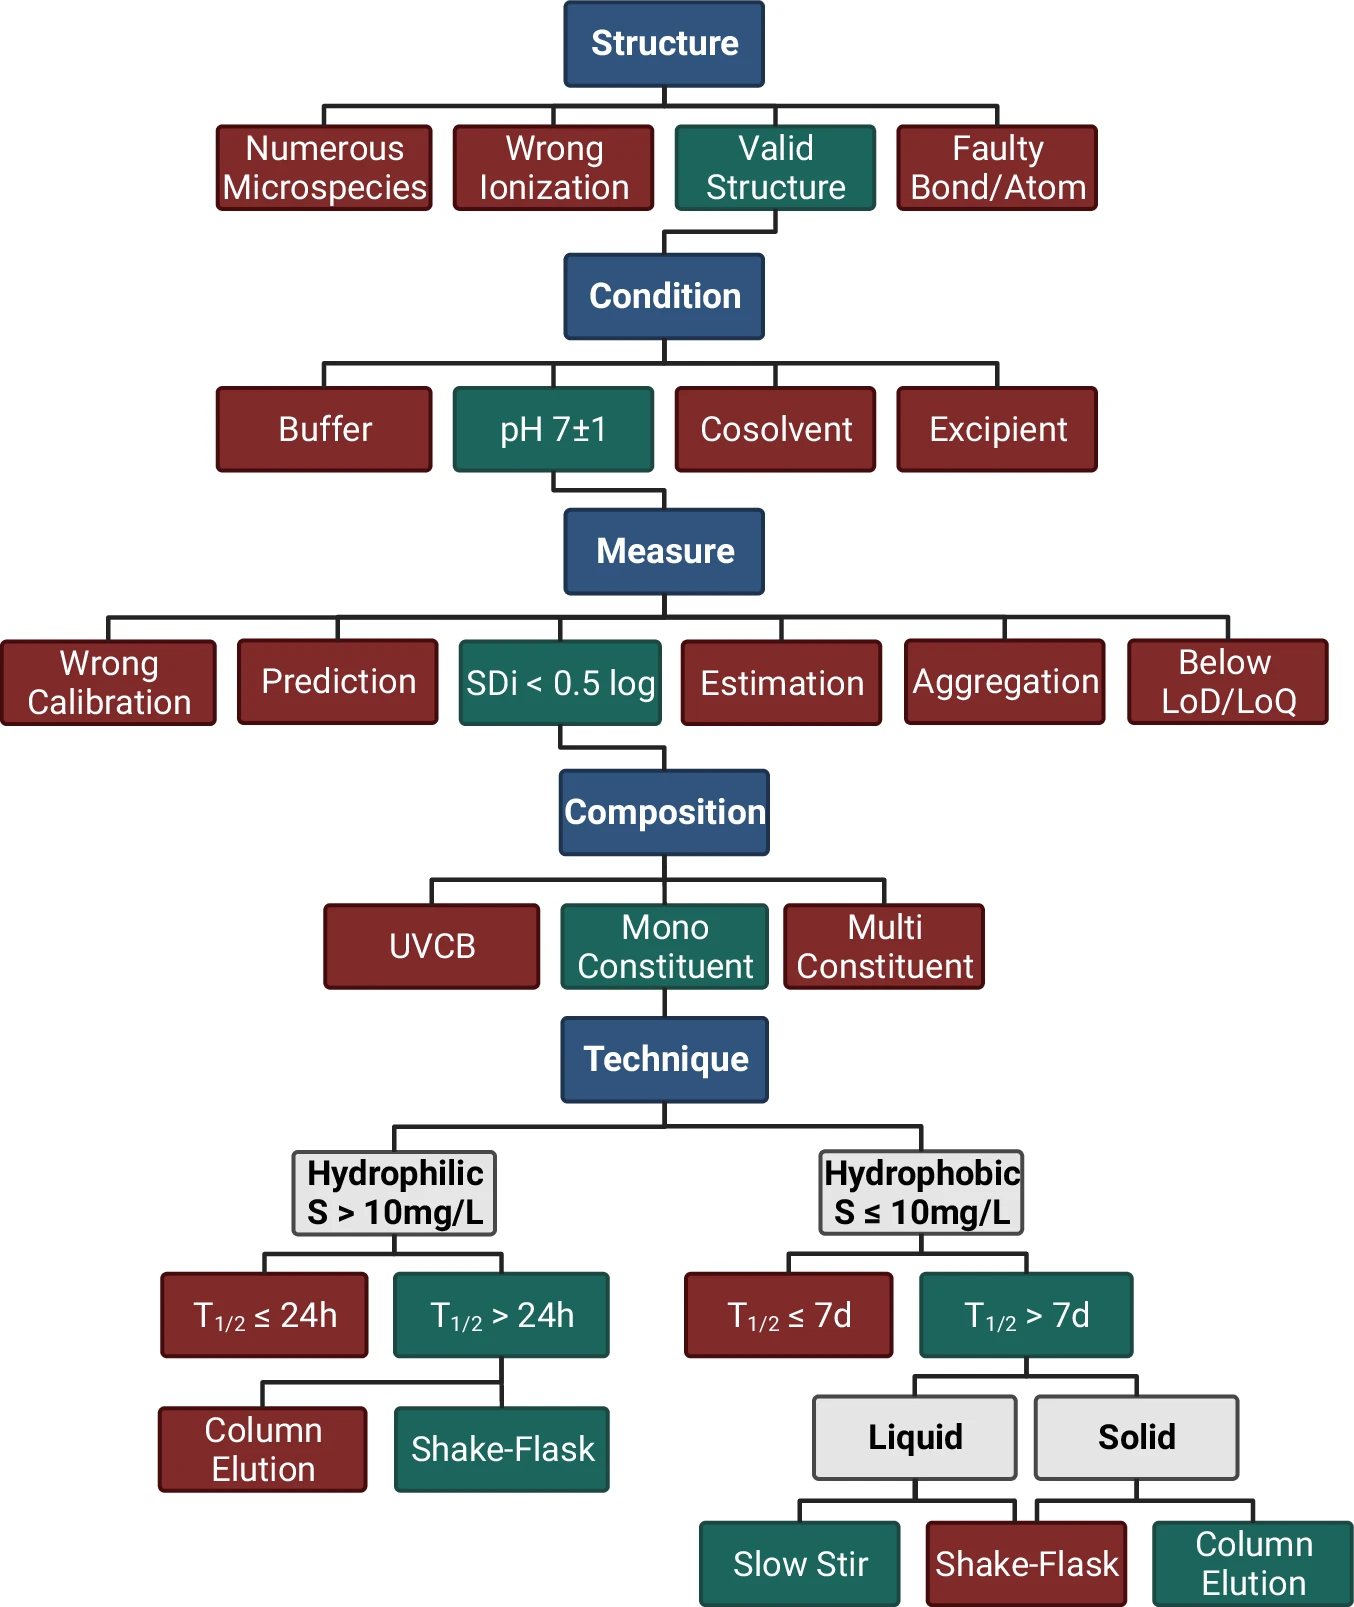

We filtered for valid structures with the curation process, the dataset is measured at pH close to 7, we do not have the standard deviation (unfortunately), and each sample was run as one constituent. The PHENOTYPE and PUBCHEM_ACTIVITY_OUTCOME use the recommended thresholds for solubility in classification.

In [21]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(
        description="Molecule SMILES string", modality="molecule"
    ),
    "PUBCHEM_ACTIVITY_OUTCOME": ColumnAnnotation(
        description="Binarized label based on the phenotype observed, active if Moderate/High Solubility (class = 1) or inactive if Low Solubility (class = 0).",
        user_attributes={"ref_col": "PHENOTYPE"},
    ),
    "PUBCHEM_ACTIVITY_SCORE": ColumnAnnotation(
        description="Whole number in solubility (ug/mL) of the compound.",
        user_attributes={"ref_col": "KINETIC AQUEOUS SOLUBILITY", "unit": "ug/mL"},
    ),
    "PHENOTYPE": ColumnAnnotation(
        description="Indicates type of activity observed: 0-10: Low Solubility (Class = 0); >10: Moderate/High Solubility (Class = 1)",
        user_attributes={"ref_col": "KINETIC AQUEOUS SOLUBILITY"},
    ),
    "KINETIC_AQUEOUS_SOLUBILITY": ColumnAnnotation(
        description="Numerical value of the observed aqueous solubility.",
        user_attributes={"unit": "ug/mL"},
    ),
}

In [22]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated[annotations.keys()],
    # Additional meta-data on the dataset level.
    name="ADME_NCATS_Solubility",
    description="ADME Solubility experiment data released by the National Center for Advancing Translational Sciences",
    source="https://doi.org/10.1016/j.bmc.2019.05.037",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Polaris", slug="polaris"),
    license="CC-BY-4.0",
    curation_reference="https://github.com/polaris-hub/polaris-recipes/04_ADME_NCATS/04_02_ADME_NCATS_Solubility_data_curation.ipynb",
    user_attributes={"year": "2021"},
)

In [23]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

/Users/lu.zhu/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


['/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmppzf6jk9u/dataset/table.parquet',
 '/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmppzf6jk9u/dataset/dataset.json']

In [24]:
folder = "04_ADME_NCATS"
data_curated.to_parquet(
    f"gs://polaris-private/curated_datasets/{folder}/{dataset.name}_curated.parquet"
)  # Save just in case. Requires a data folder.

save_dir = f"gs://polaris-private/Datasets/{folder}/{dataset.name}"
dataset.to_json(save_dir)

save_dir = f"gs://polaris-public/Datasets/{folder}/{dataset.name}"
dataset.to_json(save_dir)

# dataset.upload_to_hub()

/Users/lu.zhu/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


'gs://polaris-public/Datasets/04_ADME_NCATS/ADME_NCATS_Solubility/dataset.json'

In [25]:
d = Dataset.from_json('gs://polaris-public/Datasets/04_ADME_NCATS/ADME_NCATS_Solubility/dataset.json')
d.license =  {"id": "CC-BY-4.0", "reference": "https://creativecommons.org/licenses/by/4.0/"}
d.upload_to_hub()